# Following the Trend

### Core strategy rules

Let’s review the rules of the strategy we now have before us. This is still a fairly simple breakout strategy
with only a few bells and whistles added on top of it but used correctly it works very well:


* Long entries are only allowed if the 50-day moving average is above the 100-day moving average.
* Short entries are only allowed if the 50-day moving average is below the 100-day moving average.
* If today’s closing price is the highest close in the past 50 days, we buy.
* If today’s closing price is the lowest close in the past 50 days, we sell.
* Position sizing is volatility adjusted according to the ATR-based formula previously shown, with a risk factor of 20 basis points.
* A long position is closed when it has moved three ATR units down from its highest closing price since the position was opened.
* A short position is closed when it has moved three ATR units up from its lowest closing price since the position was opened.

***

## 1. Dependecies

In [1]:
# Import Libraries
import oandapy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from OandaFunctions import get_historical_data_date

# To not print warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Load the Data

In [2]:
# Load past data using OANDA
data = get_historical_data_date('IN50_USD', 'D', '2010-01-01', '2020-05-15')

In [3]:
# Print first 5 rows
data.head()

,open,high,low,close,volume,date,time,weekday
datetime,,,,,,,,
2011-08-26 02:30:00,4863.8,4891.2,4722.0,4751.9,13655,2011-08-26,02:30:00,4
2011-08-29 02:30:00,4813.4,4951.5,4813.2,4943.5,12319,2011-08-29,02:30:00,0
2011-08-30 02:30:00,4985.5,5024.8,4927.4,5018.7,13882,2011-08-30,02:30:00,1
2011-09-02 02:30:00,5048.2,5066.6,4991.9,5048.0,12280,2011-09-02,02:30:00,4
2011-09-05 02:30:00,4992.8,5025.8,4957.0,5016.6,12566,2011-09-05,02:30:00,0


## 3. Coding the Strategy

In [4]:
# Moving average on 50 days period
data['ma_50'] = data['close'].rolling(50).mean()

# Moving average on 100 days period
data['ma_100'] = data['close'].rolling(100).mean()

In [5]:
# Long entries are only allowed if the 50-day moving average is above the 100-day moving average
data['le'] = data['ma_50'] > data['ma_100']

# Short entries are only allowed if the 50-day moving average is below the 100-day moving average
data['se'] = data['ma_50'] < data['ma_100']

In [6]:
# If today’s closing price is the highest close in the past 50 days, we buy
data['buy'] = data.shift()['close'] >= data['close'].shift().rolling(50).max()

# If today’s closing price is the lowest close in the past 50 days, we sell
data['sell'] = data.shift()['close'] <= data['close'].shift().rolling(50).min()

In [7]:
# Go short if both conditions are true
data['short_entry'] = (data['se'] & data['sell']).apply(int)

# Go long if both conditions are true
data['long_entry'] = (data['le'] & data['buy']).apply(int)

In [8]:
# Store previous day's close
data['prev_close'] = data['close'].shift()

# True Range = Max(Today's High, Previous Close) - Min(Today's Low, Previous Close)
data['tr'] = data[['high','prev_close']].max(axis=1) - data[['low','prev_close']].min(axis=1)

# Average True Range - Exponential Moving Average of True Range
data['atr'] = data['tr'].ewm(span=100).mean()

In [9]:
# Drop rows with NaN values and columns which aren't needed anymore
data.dropna(inplace=True)
data.drop(columns= ['ma_50', 'ma_100', 'le', 'se', 'buy', 'sell', 'prev_close', 'tr'], inplace=True)

In [30]:
# Print first 5 rows
data.head()

,open,high,low,close,volume,date,time,weekday,short_entry,long_entry,atr,short,long,long_entry_price,long_exit,short_entry_price,short_exit,long_vanilla_pnl,short_vanilla_pnl,pnl
datetime,,,,,,,,,,,,,,,,,,,,
2012-01-25 03:30:00,5109.9,5138.1,5094.5,5117.6,9579,2012-01-25,03:30:00,2,NaN,NaN,97.266314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-27 03:30:00,5153.9,5168.3,5116.5,5157.2,10466,2012-01-27,03:30:00,4,NaN,NaN,96.228303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-30 03:30:00,5130.1,5132.3,5052.6,5056.5,10811,2012-01-30,03:30:00,0,NaN,NaN,96.418854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-31 03:30:00,5090.7,5186.3,5087.3,5181.9,9740,2012-01-31,03:30:00,1,NaN,NaN,97.176415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-01 03:30:00,5166.8,5225.5,5133.1,5223.8,10075,2012-02-01,03:30:00,2,NaN,NaN,97.068330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Storing the first elements before applying difference function which will replace them with NaN
first_short = data['short_entry'].iloc[0]
first_long = data['long_entry'].iloc[0]

# Apply difference to keep only first occurences of trade entries
data['short_entry'] = data['short_entry'].diff()
data['long_entry'] = data['long_entry'].diff()

# Discard -1's and replace them with 0's
data['short_entry'] = data['short_entry'].replace(-1,0)
data['long_entry'] = data['long_entry'].replace(-1,0)

# Restore the original values of the first row
data.ix[0, 'short_entry'] = first_short
data.ix[0, 'long_entry'] = first_long

In [12]:
# Create NaN columns for short and long trades
data['short'] = np.nan
data['long'] = np.nan

# Uniquely number every trade open
data.loc[data[data['short_entry'] == 1].index, 'short'] = list(range(len(data[data['short_entry']==True])))
data.loc[data[data['long_entry'] == 1].index, 'long'] = list(range(len(data[data['long_entry']==True])))

In [13]:
# Forward fill all NaN values to create open trade groups
data['short'].ffill(inplace=True)
data['long'].ffill(inplace=True)

In [14]:
# Replace 0's with NaNs
data['short_entry'] = data['short_entry'].replace(0,np.nan)
data['long_entry'] = data['long_entry'].replace(0,np.nan)

In [15]:
# Group the data by the trade number
grouped_short = data.groupby(['short'])
grouped_long = data.groupby(['long'])

In [16]:
# Create NaN columns for Long entry price
data['long_entry_price'] = np.nan

# Create NaN columns for Long exit
data['long_exit'] = np.nan

# List to store long trade groups that are accounted for
new_grp_long = []

# Create new dataframe to store individual trade groups
data_long = pd.DataFrame()

# Run for loop for all grouped trades
for grp_long, df_long in grouped_long:
    
    # If the trade is not already accounted for then run the code 
    if grp_long not in new_grp_long:
        
        # Run until exit is not found
        while True :
            
            # Check if exit exists within the trade group
            try:

                # Take the data for the group in the loop
                df_long = grouped_long.get_group(grp_long)
                
                # Append the group data to the newly created dataframe
                data_long = pd.concat([data_long, df_long])

                # Take the highest closing price since the trade was opened
                data_long['highest'] = data_long['close'].rolling(len(data_long), min_periods=1).max()

                # Exit when it has moved three ATR units down from its highest closing price 
                # since the position was opened 
                data_long['long_exit'] = (data_long['highest'] - (3 * data_long['atr'])) > data_long['low']

                # Save the index at which we have to exit
                exit_index = data_long[data_long['long_exit']==True].index[0]

                # Break the loop as exit is found
                break

            # If it doesn't, append the next group
            except:

                # Update the group number to the next one
                grp_long = grp_long+1
                
                # If the group exists...
                if (grp_long) <= len(grouped_long):
                    
                    # Add the group number to the list to store all groups that have been run 
                    new_grp_long.append(grp_long)
                
                # If it doesn't...
                else:
                    
                    # Exit on the last data point in the dataset
                    exit_index = data_long.index[-1]
                    
                    # Break out of the loop
                    break

        # The entry point is the first data point where long_entry column was true
        entry_index = data_long[data_long['long_entry']==True].index[0]
        
        # Update the entry in original dataframe
        data.loc[entry_index, 'long_entry_price'] = data.loc[entry_index, 'open']
        
        # Update the exit in original dataframe
        data.loc[exit_index, 'long_exit'] = data_long.loc[exit_index, 'highest'] - (3 * data_long.loc[exit_index, 'atr'])
        
        # Refresh and empty the temporary dataframe created
        data_long = pd.DataFrame()
        

In [17]:
# Create NaN columns for Short entry price
data['short_entry_price'] = np.nan

# Create NaN columns for Short exit
data['short_exit'] = np.nan

# List to store short trade groups that are accounted for
new_grp_short = []

# Create new dataframe to store individual trade groups
data_short = pd.DataFrame()

# Run for loop for all grouped trades
for grp_short, df_short in grouped_short:
    
    # If the trade is not already accounted for then run the code
    if grp_short not in new_grp_short:
        
        # Run until exit is not found
        while True :
            
            # Check if exit exists within the trade group
            try:

                # Take the data for the group in the loop
                df_short = grouped_short.get_group(grp_short)
                
                # Append the group data to the newly created dataframe
                data_short = pd.concat([data_short, df_short])

                # Take the lowest closing price since the trade was opened
                data_short['lowest'] = data_short['close'].rolling(len(data_short), min_periods=1).min()

                # Exit when it has moved three ATR units up from its lowest closing price 
                # since the position was opened
                data_short['short_exit'] = (data_short['lowest'] + (3 * data_short['atr'])) < data_short['high']

                # Break the loop as exit is found
                exit_index = data_short[data_short['short_exit']==True].index[0]

                # Break the loop as exit is found
                break
            
            # If it doesn't, append the next group
            except:

                # Update the group number to the next one
                grp_short = grp_short+1
                
                # If the group exists...
                if (grp_short) <= len(grouped_short):
                
                    # Add the group number to the list to store all groups that have been run
                    new_grp_short.append(grp_short)
                 
                # If it doesn't...
                else:
                    
                    # Exit on the last data point in the dataset
                    exit_index = data_short.index[-1]
                    
                    # Break out of the loop
                    break
         
        # The entry point is the first data point where short column was true
        entry_index = data_short[data_short['short_entry']==True].index[0]
        
        # Update the entry in original dataframe
        data.loc[entry_index, 'short_entry_price'] = data.loc[entry_index, 'open']

        # Update the exit in original dataframe
        data.loc[exit_index, 'short_exit'] = data_short.loc[exit_index, 'lowest'] + (3 * data_short.loc[exit_index, 'atr'])
        
        # Refresh and empty the temporary dataframe created
        data_short = pd.DataFrame()

In [18]:
# Save the long open and close prices separately without NaN rows
long_open_prices = data['long_entry_price'].dropna()
long_close_prices = data['long_exit'].dropna()

In [19]:
# Save the short open and close prices separately without NaN rows
short_open_prices = data['short_entry_price'].dropna()
short_close_prices = data['short_exit'].dropna()

In [20]:
# Reassign the long open indices with long close indices
long_open_prices.index = long_close_prices.index

# Reassign the short open indices with short close indices
short_open_prices.index = short_close_prices.index

In [21]:
# Save the Long PnL in a column
data['long_vanilla_pnl'] = long_close_prices - long_open_prices

# Save the Short PnL in a column
data['short_vanilla_pnl'] = short_open_prices - short_close_prices

In [22]:
# Combine the buy and sell PnLs, fill NAs with 0s, sum along axis 1, replace 0s with NAs, drop NAs, round everthing to 2 decimal places
data['pnl'] = np.round(data[['long_vanilla_pnl', 'short_vanilla_pnl']].fillna(0).sum(axis=1).replace(0, np.nan), 2)


In [23]:
# Save the PnL values without NaN's
pnl = data['pnl'].dropna()

## 4. Checking the results

In [24]:
# Print only the rows with entry, exit and PnL values
data['short_entry_price short_exit short_vanilla_pnl long_entry_price long_exit long_vanilla_pnl pnl'.split()].dropna(how='all')


,short_entry_price,short_exit,short_vanilla_pnl,long_entry_price,long_exit,long_vanilla_pnl,pnl
datetime,,,,,,,
2012-08-16 02:30:00,NaN,NaN,NaN,5367.8,NaN,NaN,NaN
2012-11-16 03:30:00,NaN,NaN,NaN,NaN,5580.44737,212.64737,212.65
2012-11-30 03:30:00,NaN,NaN,NaN,5843.9,NaN,NaN,NaN
2013-02-08 03:30:00,NaN,NaN,NaN,NaN,5903.46615,59.56615,59.57
2013-04-05 02:30:00,5563.9,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-01-30 03:30:00,NaN,NaN,NaN,NaN,11993.38936,-370.01064,-370.01
2020-03-10 02:30:00,10444.6,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-12 02:30:00,NaN,9546.039068,898.560932,NaN,NaN,NaN,898.56


In [25]:
# Print the metrics
# Long PnL, Short PnL, Total PnL, Win Rate, Risk:Reward and Maximum Drawdown
print('Long PnL : ', np.round(data['long_vanilla_pnl'].sum(), 2))
print('Short PnL : ', np.round(data['short_vanilla_pnl'].sum(), 2))
print('Total PnL : ', np.round(data['short_vanilla_pnl'].sum() + data['long_vanilla_pnl'].sum(), 2))
print('Win Rate % : ', np.round((sum(pnl > 0)/len(pnl))*100, 2))
print('Risk:Reward : ', np.round(abs(pnl[pnl > 0].mean()/pnl[pnl < 0].mean()), 2))
print('Max Drawdown : ', np.round(pnl.cumsum().min(), 2))

Long PnL :  1229.89
Short PnL :  -271.07
Total PnL :  958.81
Win Rate % :  48.48
Risk:Reward :  1.28
Max Drawdown :  -641.93


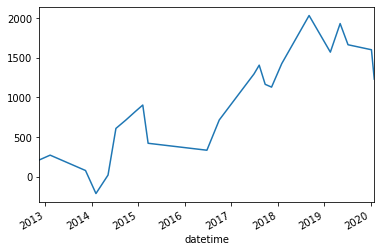

In [26]:
# Print the cumulative Long PnL plot
data['long_vanilla_pnl'].dropna().cumsum().plot()

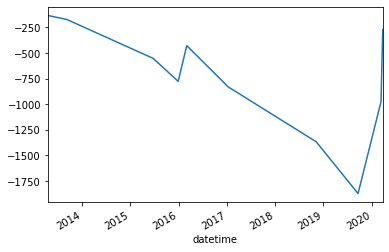

In [27]:
# Print the cumulative Short PnL plot
data['short_vanilla_pnl'].dropna().cumsum().plot()

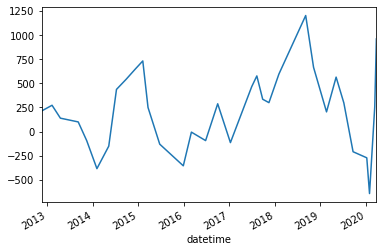

In [28]:
# Print the cumulative PnL plot
pnl.cumsum().plot()

***